# PRIO Press Release: Draft Watchlist

This notebook extracts data from the ViEWS system to generate two watchlists. The first is a watchlist for high-violence countries, generating information on the top 5 countries with the highest total predicted fatalities over the course of 2024. The second watchlist is for low-violence countries. Using UCDP data integrated within the VIEWSER system a list of top 5 countries with the highest total predicted fatalities over the course of 2024 who have not yet observed 25 battle-related deaths thus far over the course of 2023 will be generated.



In [3]:
import requests
import numpy as np
import pandas as pd

# Visulisations
import matplotlib.pyplot as plt
import seaborn as sns

#import matplotlib as mpl

# ViEWS operations 
from viewser.operations import fetch
from viewser import Queryset, Column
# ensure viewser is 5.14.1

import views_runs
from views_partitioning import data_partitioner, legacy
from stepshift import views
from ingester3.ViewsMonth import ViewsMonth # not included in example scripts, but is required

# from views_mapper2.label_writer import * # cannot import without certificates. Example scripts to fetch UCDP GED state it is required, but that does not appear to be the case 

import os
home = os.path.expanduser("~")

desktop = home+'/Desktop' # (Toggle on to save to desktop) 
# Can change to save to dropbox. Depends on where things should be saved as the project transitions to notion.


## Part 1: Fetching and downloading data from ViEWS API. 

In [139]:
# Fetch data URL - could each itiration be fetched in the same loop?
views_url_09 = 'https://api.viewsforecasting.org/fatalities002_2023_09_t01/cm/sb'
print(views_url_09)

# Page size
page_size_09 = 1000

# Request function and defining full request
r_09 = requests.get(views_url_09)
master_list_09 = []

page_data_09 = r_09.json()
list(page_data_09)

# Loop to fetch data until all is accessed
master_list_09 += page_data_09['data']

while page_data_09['next_page'] != '':
    r_09 = requests.get(page_data_09['next_page'])
    page_data_09 = r_09.json()
    master_list_09 += page_data_09['data']

https://api.viewsforecasting.org/fatalities002_2023_09_t01/cm/sb


In [141]:
df_views_09 = pd.DataFrame(master_list_09)
list(df_views_09.columns.values)

columns_to_keep = ['country_id', 'month_id', 'name', 'gwcode', 'year', 'main_mean', 'isoab']

# creating new df
new_df_views_09 = df_views_09[columns_to_keep]
new_df_views_09

,country_id,month_id,name,gwcode,year,main_mean,isoab
0,1,526,Guyana,110,2023,0.0173,GUY
1,2,526,Suriname,115,2023,0.0148,SUR
2,3,526,Trinidad and Tobago,52,2023,0.0098,TTO
3,4,526,Venezuela,101,2023,1.8027,VEN
4,5,526,Samoa,990,2023,0.0113,WSM
...,...,...,...,...,...,...,...
6871,242,561,Tanzania,510,2026,1.3106,TZA
6872,243,561,Morocco,600,2026,0.7701,MAR
6873,244,561,Mauritania,435,2026,0.9786,MRT
6874,245,561,Sudan,625,2026,140.9269,SDN


## Part 2: Fetching 2023 UCDP GED Data 

In [87]:
def vid2date(i):
    year=str(1980 + i//12)
    month=str(i%12)
    return year+'/'+month

# Printing month_ids for chosen period
print(ViewsMonth.from_year_month(year=2023, month=1))

ViewsMonth(id=517) #=> year:2023, month:1


In [187]:
StartOfHistory = 517 # January 2024
EndOfHistory = 525 # September 2024, 2024 so far

# no data september or october, should it be accessible?

In [ ]:
# To see possible tables and Querysets from viewser

#!viewser queryset list
#!viewser tables list

# example to explore a viewser table 

#!viewser tables show "faostat_pp_cm

In [89]:
qs_ged_cm = (Queryset("AT_cm_ged_data_no_transformations", "country_month")
             .with_column(Column("year", from_table="month", from_column="year_id"))
             .with_column(Column('month', from_table='month', from_column='month'))
             .with_column(Column('country_name', from_table='country', from_column='name'))
             .with_column(Column("ged_best_sb", from_table="ged2_cm", from_column="ged_sb_best_sum_nokgi"))
             .with_column(Column("ged_best_os", from_table="ged2_cm", from_column="ged_os_best_sum_nokgi"))
             .with_column(Column("ged_best_ns", from_table="ged2_cm", from_column="ged_ns_best_sum_nokgi")))

qs_ged_cm = qs_ged_cm.publish().fetch()

print(f"A dataset with {len(qs_ged_cm.columns)} columns, with "
      f"data between t {min(qs_ged_cm.index.get_level_values(0))} "
      f"and {max(qs_ged_cm.index.get_level_values(0))}. "
      f"({len(np.unique(qs_ged_cm.index.get_level_values(1)))} units)"
     )

 .     A dataset with 6 columns, with data between t 1 and 852. (213 units)


In [188]:
qs_ged_cm

year  month         country_name  ged_best_sb  \
month_id country_id                                                  
1        1           1980      1               Guyana          NaN   
         2           1980      1             Suriname          NaN   
         3           1980      1  Trinidad and Tobago          NaN   
         4           1980      1            Venezuela          NaN   
         5           1980      1                Samoa          NaN   
...                   ...    ...                  ...          ...   
852      242         2050     12             Tanzania          NaN   
         243         2050     12              Morocco          NaN   
         244         2050     12           Mauritania          NaN   
         245         2050     12                Sudan          NaN   
         246         2050     12          South Sudan          NaN   

                     ged_best_os  ged_best_ns  
month_id country_id                            
1        1                   NaN          NaN  
         2                   NaN          NaN  
         3                   NaN          NaN  
         4                   NaN          NaN  
         5                   NaN          NaN  
...                          ...          ...  
852      242                 NaN          NaN  
         243                 NaN          NaN  
         244                 NaN          NaN  
         245                 NaN          NaN  
         246                 NaN          NaN  

[158230 rows x 6 columns]

In [189]:
# From Jan 2023 to Aug 2023
# displays the subset
ged_cm_subset= qs_ged_cm.query(f'month_id >= {StartOfHistory} and month_id <= {EndOfHistory}')

ged_cm_subset

year  month         country_name  ged_best_sb  \
month_id country_id                                                  
517      1           2023      1               Guyana          0.0   
         2           2023      1             Suriname          0.0   
         3           2023      1  Trinidad and Tobago          0.0   
         4           2023      1            Venezuela          0.0   
         5           2023      1                Samoa          0.0   
...                   ...    ...                  ...          ...   
525      242         2023      9             Tanzania          0.0   
         243         2023      9              Morocco          0.0   
         244         2023      9           Mauritania          0.0   
         245         2023      9                Sudan        510.0   
         246         2023      9          South Sudan          0.0   

                     ged_best_os  ged_best_ns  
month_id country_id                            
517      1                   0.0          0.0  
         2                   0.0          0.0  
         3                   0.0          0.0  
         4                   3.0          0.0  
         5                   0.0          0.0  
...                          ...          ...  
525      242                 0.0          0.0  
         243                 0.0          0.0  
         244                 0.0          0.0  
         245                 3.0          0.0  
         246                 1.0          0.0  

[1719 rows x 6 columns]

In [92]:
# Specify the columns to keep
columns_to_keep_ged = ['country_name', 'ged_best_sb']

# Filter the DataFrame to retain only the specified columns
ged_df = ged_cm_subset[columns_to_keep_ged]

ged_df['total_ged'] = ged_df.groupby('country_name')['ged_best_sb'].transform('sum')

ged_df

/var/folders/t3/40l96qbj5mlfwpyyhs6h6k8r0000gq/T/ipykernel_6991/2732747813.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ged_df['total_ged'] = ged_df.groupby('country_name')['ged_best_sb'].transform('sum')


country_name  ged_best_sb  total_ged
month_id country_id                                             
517      1                        Guyana          0.0        0.0
         2                      Suriname          0.0        0.0
         3           Trinidad and Tobago          0.0        0.0
         4                     Venezuela          0.0       11.0
         5                         Samoa          0.0        0.0
...                                  ...          ...        ...
525      242                    Tanzania          0.0        0.0
         243                     Morocco          0.0        1.0
         244                  Mauritania          0.0        6.0
         245                       Sudan        510.0     2353.0
         246                 South Sudan          0.0       12.0

[1719 rows x 3 columns]

## Part 3: Creating High-Violence Watchlist

In [142]:
# Filtering for 2024
df_2024_views = new_df_views_09[(new_df_views_09['year'] == 2024)]

# Sum of total predicted fatalities over 2024 for each country
df_2024_views_group = df_2024_views.groupby(['name'])['main_mean'].sum().reset_index()

df_2024_views_group

,name,main_mean
0,Afghanistan,537.1252
1,Albania,1.0546
2,Algeria,8.8483
3,Angola,4.5910
4,Antigua and Barbuda,0.2926
...,...,...
186,Venezuela,29.0167
187,Vietnam,14.4592
188,Yemen,1153.3253
189,Zambia,1.3319


In [182]:
list(df_2024_views_group.name.unique())
#list(ged_df_filter.country_name.unique())

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Congo, DRC',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Iran',

In [184]:
views_ukraine_train = df_2024_views_group[(df_2024_views_group['name'] == 'Ukraine')]
views_ukraine_train # Ukraine is there, but does not make the top 5. Comes in at 6.

,name,main_mean
179,Ukraine,3552.0427


In [143]:
# Pulling the top five countries
n = 5
df_top_hv_2024 = df_2024_views_group.nlargest(n, 'main_mean')

# need to work on style to create a nicer looking table (encountered error, in process of fixing)

df_top_hv_2024.reset_index(drop=True, inplace=True)
df_top_hv_2024.index = df_top_hv_2024.index + 1

df_top_hv_2024.index.name = 'Ranking'
# rename column main_mean

df_top_hv_2024

,name,main_mean
Ranking,,
1,Syria,4999.0411
2,Nigeria,4722.3352
3,Somalia,4399.0770
4,Myanmar,3882.0366
5,Burkina Faso,3779.3527


In [144]:
df_top_hv_2024 = df_top_hv_2024.rename(columns={'name': 'Country', 'main_mean': 'Total Predicted Fatalities for 2024'})

df_top_hv_2024

,Country,Total Predicted Fatalities for 2024
Ranking,,
1,Syria,4999.0411
2,Nigeria,4722.3352
3,Somalia,4399.0770
4,Myanmar,3882.0366
5,Burkina Faso,3779.3527


**** Syria, Nigeria, Myanmar, Somalia, and Burkina Faso are the top five countries with highest predicted fatalities for 2024 based on the October run. There is a good chance that future runs will include Israel in the top five, but the neccessary conflict history that would influence result was not yet ingested for the October run. ***

Above was written before November run was finished. When using the November run it is the same top five countries, but Somalia and Myanmar switch places. Additionally, the range of total predicted fatailites decreases; however, all total predicted fatailites have increased for all countries except for Syria. 

In [145]:
#Top five countries 
countries_to_filter = ['Syria', 'Nigeria', 'Myanmar', 'Somalia', 'Burkina Faso']

df_country_filter = df_2024_views[df_2024_views['name'].isin(countries_to_filter)]

columns_to_keep_cm = ['month_id', 'name', 'main_mean', 'country_id'] # only required columns for heatmap
df_country_filter_cm = df_country_filter[columns_to_keep_cm]

df_country_filter_cm.set_index(['month_id','country_id'], inplace=True) # setting name as index
df_country_filter_cm #Process for pivoted table to generate heatmap

name  main_mean
month_id country_id                         
529      47          Burkina Faso   354.5667
         79               Nigeria   315.8884
         120              Somalia   404.0725
         149              Myanmar   290.6698
         220                Syria   268.2791
530      47          Burkina Faso   586.4341
         79               Nigeria   425.1556
         120              Somalia   895.9494
         149              Myanmar   310.3757
         220                Syria   333.2893
531      47          Burkina Faso   459.1501
         79               Nigeria   542.5549
         120              Somalia   566.9600
         149              Myanmar   474.7049
         220                Syria   625.0493
532      47          Burkina Faso   377.1450
         79               Nigeria   469.6317
         120              Somalia   445.6062
         149              Myanmar   397.1749
         220                Syria   466.0050
533      47          Burkina Faso   342.2431
         79               Nigeria   478.0123
         120              Somalia   315.7733
         149              Myanmar   324.0843
         220                Syria   368.3730
534      47          Burkina Faso   258.9826
         79               Nigeria   349.9635
         120              Somalia   225.7696
         149              Myanmar   416.7345
         220                Syria   316.0292
535      47          Burkina Faso   206.6257
         79               Nigeria   352.4316
         120              Somalia   244.3460
         149              Myanmar   334.6679
         220                Syria   427.5137
536      47          Burkina Faso   237.4282
         79               Nigeria   446.1803
         120              Somalia   275.0497
         149              Myanmar   358.7742
         220                Syria   435.1350
537      47          Burkina Faso   233.1252
         79               Nigeria   378.6321
         120              Somalia   251.5827
         149              Myanmar   434.9754
         220                Syria   503.7834
538      47          Burkina Faso   241.6181
         79               Nigeria   416.4121
         120              Somalia   329.6263
         149              Myanmar   177.5347
         220                Syria   578.7530
539      47          Burkina Faso   247.5811
         79               Nigeria   261.0120
         120              Somalia   274.7566
         149              Myanmar   198.3087
         220                Syria   352.0252
540      47          Burkina Faso   234.4528
         79               Nigeria   286.4607
         120              Somalia   169.5847
         149              Myanmar   164.0316
         220                Syria   324.8059

In [146]:
# pivoting dataframe to have data in correct format for visulisations
pivot_df_country_cm = df_country_filter_cm.pivot_table(index='name', columns='month_id', values='main_mean', aggfunc='sum')
pivot_df_country_cm #Each month_id = column, indexed by country, values predicted fatalities 

month_id,529,530,531,532,533,534,535,536,537,538,539,540
name,,,,,,,,,,,,
Burkina Faso,354.5667,586.4341,459.1501,377.1450,342.2431,258.9826,206.6257,237.4282,233.1252,241.6181,247.5811,234.4528
Myanmar,290.6698,310.3757,474.7049,397.1749,324.0843,416.7345,334.6679,358.7742,434.9754,177.5347,198.3087,164.0316
Nigeria,315.8884,425.1556,542.5549,469.6317,478.0123,349.9635,352.4316,446.1803,378.6321,416.4121,261.0120,286.4607
Somalia,404.0725,895.9494,566.9600,445.6062,315.7733,225.7696,244.3460,275.0497,251.5827,329.6263,274.7566,169.5847
Syria,268.2791,333.2893,625.0493,466.0050,368.3730,316.0292,427.5137,435.1350,503.7834,578.7530,352.0252,324.8059


In [147]:
# Process to keep ranking of countries within the dataframe for the heatmap
df_hv_pivot = df_country_filter[columns_to_keep_cm]

merged_hv = pd.merge(df_hv_pivot, df_top_hv_2024, left_on='name', right_on='Country')
# pandas default is inner join, technically appropriate here bc is pulling from same data 

# which columns to remove: name 

merged_hv_filter = merged_hv.drop(columns='name')

merged_hv_filter.set_index(['month_id','country_id'], inplace=True)

# need to keep some columns prior to doing the index by country_id, month_id 
# want to match name to country and drop one of the columns 

merged_hv_filter


,,main_mean,Country,Total Predicted Fatalities for 2024
month_id,country_id,,,
529,47,354.5667,Burkina Faso,3779.3527
530,47,586.4341,Burkina Faso,3779.3527
531,47,459.1501,Burkina Faso,3779.3527
532,47,377.1450,Burkina Faso,3779.3527
533,47,342.2431,Burkina Faso,3779.3527
534,47,258.9826,Burkina Faso,3779.3527
535,47,206.6257,Burkina Faso,3779.3527
536,47,237.4282,Burkina Faso,3779.3527
537,47,233.1252,Burkina Faso,3779.3527


In [148]:
df_hv_rank = merged_hv_filter.sort_values(by='Total Predicted Fatalities for 2024', ascending=False)

df_hv_rank

,,main_mean,Country,Total Predicted Fatalities for 2024
month_id,country_id,,,
540,220,324.8059,Syria,4999.0411
534,220,316.0292,Syria,4999.0411
529,220,268.2791,Syria,4999.0411
530,220,333.2893,Syria,4999.0411
531,220,625.0493,Syria,4999.0411
533,220,368.3730,Syria,4999.0411
532,220,466.0050,Syria,4999.0411
535,220,427.5137,Syria,4999.0411
536,220,435.1350,Syria,4999.0411


In [149]:
pivot_df_hv_rank = df_hv_rank.pivot_table(index='Country', columns='month_id', values='main_mean', aggfunc='sum', sort=False)
pivot_df_hv_rank # sorted in order of top 1-5

month_id,529,530,531,532,533,534,535,536,537,538,539,540
Country,,,,,,,,,,,,
Syria,268.2791,333.2893,625.0493,466.0050,368.3730,316.0292,427.5137,435.1350,503.7834,578.7530,352.0252,324.8059
Nigeria,315.8884,425.1556,542.5549,469.6317,478.0123,349.9635,352.4316,446.1803,378.6321,416.4121,261.0120,286.4607
Somalia,404.0725,895.9494,566.9600,445.6062,315.7733,225.7696,244.3460,275.0497,251.5827,329.6263,274.7566,169.5847
Myanmar,290.6698,310.3757,474.7049,397.1749,324.0843,416.7345,334.6679,358.7742,434.9754,177.5347,198.3087,164.0316
Burkina Faso,354.5667,586.4341,459.1501,377.1450,342.2431,258.9826,206.6257,237.4282,233.1252,241.6181,247.5811,234.4528


### Part 3.1: High-Violence Visualisations

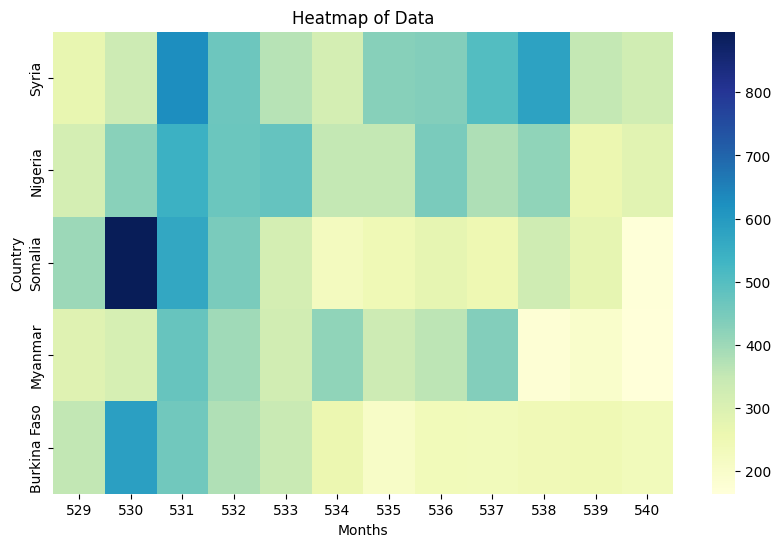

In [150]:
# creating heatmap
plt.figure(figsize =(10, 6)) # Adjust figure size as needed
sns.heatmap(pivot_df_hv_rank, cmap='YlGnBu', vmin=pivot_df_hv_rank.values.min(), vmax=pivot_df_hv_rank.values.max())

# Adding labels and title
plt.xlabel('Months') # is it possible to add these all together into one line of code?
plt.ylabel('Country')
plt.title('Heatmap of Data')

# Displaying heatmap
plt.show() # reworking for better visuals (in progress)

# add legend for colours 
# need to put countries in ranking order - currenlty in alphabetical

In [ ]:
#plt.plot(pivot_df_lv_rank['month_id'], pivot_df_lv_rank['Country'])
# X then Y statements - could take new dataframe with main_mean X and month_id Y + each line grouped by Country. Try to change line style to dashed when time turns to future. Create dataframe combining known BRDs plus predictions 

# creating dataframe for plt 

# fetching UCDP GED data for HV (move qs_ged_cm cell block up here)

In [151]:
# selecting only the top 5 HV countries from ged_df using countries_to_filter

ged_df_hv = ged_df[ged_df['country_name'].isin(countries_to_filter)]

ged_df_hv # want month_id as a column


country_name  ged_best_sb  total_ged
month_id country_id                                      
517      47          Burkina Faso        153.0     3381.0
         79               Nigeria        466.0     2705.0
         120              Somalia        574.0     3645.0
         149              Myanmar        128.0     1605.0
         220                Syria         92.0     1056.0
518      47          Burkina Faso        367.0     3381.0
         79               Nigeria        320.0     2705.0
         120              Somalia        821.0     3645.0
         149              Myanmar        101.0     1605.0
         220                Syria        161.0     1056.0
519      47          Burkina Faso        479.0     3381.0
         79               Nigeria        250.0     2705.0
         120              Somalia        334.0     3645.0
         149              Myanmar        188.0     1605.0
         220                Syria        129.0     1056.0
520      47          Burkina Faso        428.0     3381.0
         79               Nigeria        257.0     2705.0
         120              Somalia         87.0     3645.0
         149              Myanmar        339.0     1605.0
         220                Syria        117.0     1056.0
521      47          Burkina Faso        306.0     3381.0
         79               Nigeria        200.0     2705.0
         120              Somalia        315.0     3645.0
         149              Myanmar        131.0     1605.0
         220                Syria         64.0     1056.0
522      47          Burkina Faso        599.0     3381.0
         79               Nigeria        338.0     2705.0
         120              Somalia        226.0     3645.0
         149              Myanmar        218.0     1605.0
         220                Syria         85.0     1056.0
523      47          Burkina Faso        288.0     3381.0
         79               Nigeria        555.0     2705.0
         120              Somalia        477.0     3645.0
         149              Myanmar        145.0     1605.0
         220                Syria         87.0     1056.0
524      47          Burkina Faso        350.0     3381.0
         79               Nigeria        156.0     2705.0
         120              Somalia        233.0     3645.0
         149              Myanmar        176.0     1605.0
         220                Syria        191.0     1056.0
525      47          Burkina Faso        411.0     3381.0
         79               Nigeria        163.0     2705.0
         120              Somalia        578.0     3645.0
         149              Myanmar        179.0     1605.0
         220                Syria        130.0     1056.0

In [152]:
ged_df_hv = ged_df_hv.reset_index(level=['month_id'])
ged_df_hv # month_id as column


,month_id,country_name,ged_best_sb,total_ged
country_id,,,,
47,517,Burkina Faso,153.0,3381.0
79,517,Nigeria,466.0,2705.0
120,517,Somalia,574.0,3645.0
149,517,Myanmar,128.0,1605.0
220,517,Syria,92.0,1056.0
47,518,Burkina Faso,367.0,3381.0
79,518,Nigeria,320.0,2705.0
120,518,Somalia,821.0,3645.0
149,518,Myanmar,101.0,1605.0


In [ ]:
# merge ged with predictions - would create a bunch of NAN values bc diff time frames. Could combine ged_best and predictions into same column - making it the 'X' column for plotting purposes 

# OR plot predictions for 2023 aganist GED plus 2024 predicitions in dotted line?

# WORK ON LATER - move to what is explaining the predictions (aka what are the potential drivers) 

#### 3.2 Historic UCDP Trends for HV countries 

In [107]:
# Fetching UCDP data (historic conflict trends) past ??? years 
# Do 5 (2018-2023), 3 (2020-2023), and 1 (2022 aug-2023 aug) year

print(ViewsMonth.from_year_month(year=2018, month=1))
print(ViewsMonth.from_year_month(year=2020, month=1))
print(ViewsMonth.from_year_month(year=2022, month=1))

ViewsMonth(id=457) #=> year:2018, month:1
ViewsMonth(id=481) #=> year:2020, month:1
ViewsMonth(id=505) #=> year:2022, month:1


In [109]:
StartOfHistory_2018 = 457 # January 2018
StartOfHistory_2020 = 481 # January 2020
StartOfHistory_2022 = 505 # January 2020
EndOfHistory = 525 # September 2023, 2023 so far

In [110]:
ged_cm_subset_2018= qs_ged_cm.query(f'month_id >= {StartOfHistory_2018} and month_id <= {EndOfHistory}')

ged_cm_subset_2018

year  month         country_name  ged_best_sb  \
month_id country_id                                                  
457      1           2018      1               Guyana          0.0   
         2           2018      1             Suriname          0.0   
         3           2018      1  Trinidad and Tobago          0.0   
         4           2018      1            Venezuela          0.0   
         5           2018      1                Samoa          0.0   
...                   ...    ...                  ...          ...   
525      242         2023      9             Tanzania          0.0   
         243         2023      9              Morocco          0.0   
         244         2023      9           Mauritania          0.0   
         245         2023      9                Sudan        510.0   
         246         2023      9          South Sudan          0.0   

                     ged_best_os  ged_best_ns  
month_id country_id                            
457      1                   0.0          0.0  
         2                   0.0          0.0  
         3                   0.0          0.0  
         4                   0.0          0.0  
         5                   0.0          0.0  
...                          ...          ...  
525      242                 0.0          0.0  
         243                 0.0          0.0  
         244                 0.0          0.0  
         245                 3.0          0.0  
         246                 1.0          0.0  

[13179 rows x 6 columns]

In [195]:
# filter for only the HV countries

ged_hv_2018 = ged_cm_subset_2018[ged_cm_subset_2018['country_name'].isin(countries_to_filter)]

ged_hv_2018 # next steps: drop year and month columns, set month_id as column (keep country_id as index)

year  month  country_name  ged_best_sb  ged_best_os  \
month_id country_id                                                        
457      47          2018      1  Burkina Faso          3.0          0.0   
         79          2018      1       Nigeria         90.0         75.0   
         120         2018      1       Somalia         74.0          0.0   
         149         2018      1       Myanmar          7.0          0.0   
         220         2018      1         Syria       1801.0         10.0   
...                   ...    ...           ...          ...          ...   
525      47          2023      9  Burkina Faso        411.0         32.0   
         79          2023      9       Nigeria        163.0         69.0   
         120         2023      9       Somalia        578.0          0.0   
         149         2023      9       Myanmar        179.0         44.0   
         220         2023      9         Syria        130.0          2.0   

                     ged_best_ns  
month_id country_id               
457      47                  0.0  
         79                197.0  
         120                20.0  
         149                 0.0  
         220               623.0  
...                          ...  
525      47                  0.0  
         79                 85.0  
         120                 0.0  
         149                 0.0  
         220               129.0  

[345 rows x 6 columns]

In [192]:
ged_trend_columns = ['country_name', 'ged_best_sb']

# remove os and ns

# should only sb be kept? What types of fatailites is main_mean predicting

ged_hv_2018_all_trends = ged_hv_2018[ged_trend_columns]

ged_hv_2018_all_trends

# Specify the columns to keep
#columns_to_keep_ged = ['country_name', 'ged_best_sb']

# Filter the DataFrame to retain only the specified columns
#ged_df = ged_cm_subset[columns_to_keep_ged]

#ged_df['total_ged'] = ged_df.groupby('country_name')['ged_best_sb'].transform('sum')



country_name  ged_best_sb
month_id country_id                           
457      47          Burkina Faso          3.0
         79               Nigeria         90.0
         120              Somalia         74.0
         149              Myanmar          7.0
         220                Syria       1801.0
...                           ...          ...
525      47          Burkina Faso        411.0
         79               Nigeria        163.0
         120              Somalia        578.0
         149              Myanmar        179.0
         220                Syria        130.0

[345 rows x 2 columns]

In [193]:
ged_cm_subset_2020= qs_ged_cm.query(f'month_id >= {StartOfHistory_2020} and month_id <= {EndOfHistory}')

ged_cm_subset_2020

year  month         country_name  ged_best_sb  \
month_id country_id                                                  
481      1           2020      1               Guyana          0.0   
         2           2020      1             Suriname          0.0   
         3           2020      1  Trinidad and Tobago          0.0   
         4           2020      1            Venezuela          0.0   
         5           2020      1                Samoa          0.0   
...                   ...    ...                  ...          ...   
525      242         2023      9             Tanzania          0.0   
         243         2023      9              Morocco          0.0   
         244         2023      9           Mauritania          0.0   
         245         2023      9                Sudan        510.0   
         246         2023      9          South Sudan          0.0   

                     ged_best_os  ged_best_ns  
month_id country_id                            
481      1                   0.0          0.0  
         2                   0.0          0.0  
         3                   0.0          0.0  
         4                   3.0          0.0  
         5                   0.0          0.0  
...                          ...          ...  
525      242                 0.0          0.0  
         243                 0.0          0.0  
         244                 0.0          0.0  
         245                 3.0          0.0  
         246                 1.0          0.0  

[8595 rows x 6 columns]

In [194]:
ged_cm_subset_2022= qs_ged_cm.query(f'month_id >= {StartOfHistory_2022} and month_id <= {EndOfHistory}')

ged_cm_subset_2022

year  month         country_name  ged_best_sb  \
month_id country_id                                                  
505      1           2022      1               Guyana          0.0   
         2           2022      1             Suriname          0.0   
         3           2022      1  Trinidad and Tobago          0.0   
         4           2022      1            Venezuela          0.0   
         5           2022      1                Samoa          0.0   
...                   ...    ...                  ...          ...   
525      242         2023      9             Tanzania          0.0   
         243         2023      9              Morocco          0.0   
         244         2023      9           Mauritania          0.0   
         245         2023      9                Sudan        510.0   
         246         2023      9          South Sudan          0.0   

                     ged_best_os  ged_best_ns  
month_id country_id                            
505      1                   0.0          0.0  
         2                   0.0          0.0  
         3                   0.0          0.0  
         4                   0.0          0.0  
         5                   0.0          0.0  
...                          ...          ...  
525      242                 0.0          0.0  
         243                 0.0          0.0  
         244                 0.0          0.0  
         245                 3.0          0.0  
         246                 1.0          0.0  

[4011 rows x 6 columns]

##### 3.2.1. Syria 

In [204]:
# selecting only for syria from UCDP GED (using 2018 example)

ged_syria_subset_2018 = ged_hv_2018_all_trends[ged_hv_2018_all_trends['country_name'] == 'Syria']

ged_syria_subset_2018 = ged_syria_subset_2018.reset_index(level=['month_id'])
ged_syria_subset_2018

,month_id,country_name,ged_best_sb
country_id,,,
220,457,Syria,1801.0
220,458,Syria,1958.0
220,459,Syria,2964.0
220,460,Syria,1180.0
220,461,Syria,958.0
...,...,...,...
220,521,Syria,64.0
220,522,Syria,85.0
220,523,Syria,87.0


In [199]:
# combine with syria predictions from october 2023 through 2024 in a graph 

# fetching views predictions october 2024 through

## Filtering based on month_id to pull correct subset 

df_0823_1224 = new_df_views_09[(new_df_views_09['month_id'] >= 526) & (new_df_views_09['month_id'] <= 540)]

df_0823_1224_hv = df_0823_1224[df_0823_1224['name'].isin(countries_to_filter)]
df_0823_1224_hv = df_0823_1224_hv[columns_to_keep_cm]

df_0823_1224_hv
#df_country_filter = df_2024_views[df_2024_views['name'].isin(countries_to_filter)]


,month_id,name,main_mean,country_id
44,526,Burkina Faso,492.3759,47
69,526,Nigeria,255.5369,79
106,526,Somalia,484.8662,120
134,526,Myanmar,277.6730,149
177,526,Syria,180.6641,220
...,...,...,...,...
2718,540,Burkina Faso,234.4528,47
2743,540,Nigeria,286.4607,79
2780,540,Somalia,169.5847,120
2808,540,Myanmar,164.0316,149


In [202]:
# Syria 

df_0823_1224_syria = df_0823_1224_hv[df_0823_1224_hv['name'] == 'Syria']
df_0823_1224_syria.set_index(['country_id'], inplace=True)
df_0823_1224_syria

,month_id,name,main_mean
country_id,,,
220,526,Syria,180.6641
220,527,Syria,215.1650
220,528,Syria,168.5402
220,529,Syria,268.2791
220,530,Syria,333.2893
220,531,Syria,625.0493
220,532,Syria,466.0050
220,533,Syria,368.3730
220,534,Syria,316.0292


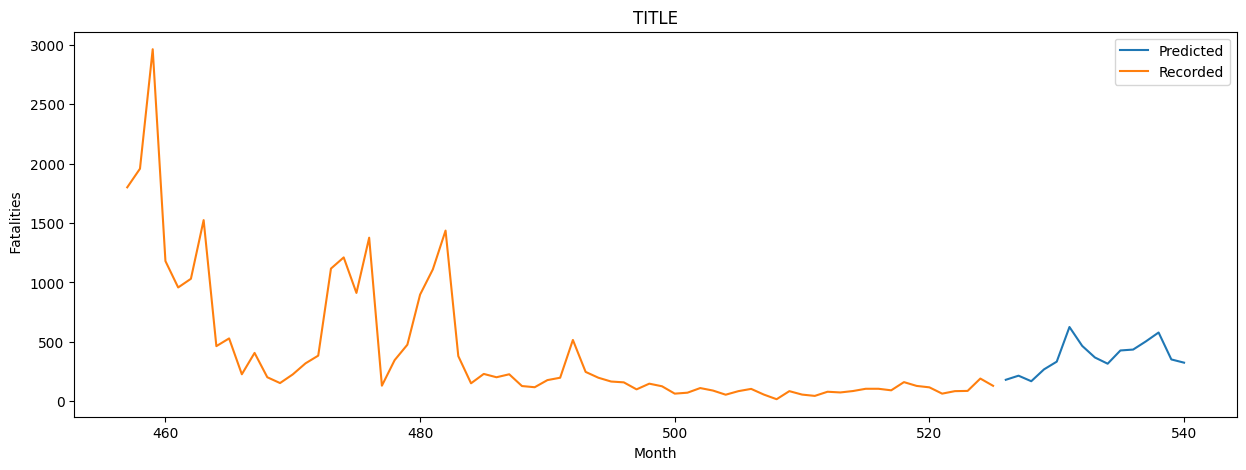

In [205]:
# ploting syria recorded fatalities and predicted
# line graph pulling from four diff fat runs 

plt.plot(df_0823_1224_syria['month_id'], df_0823_1224_syria['main_mean'], label='Predicted') #come up with label names, change to dashed/dotted line
plt.plot(ged_syria_subset_2018['month_id'], ged_syria_subset_2018['ged_best_sb'], label='Recorded')


#set_figwidth()
plt.rcParams["figure.figsize"] = (15, 5) # REVISE

# Customize
plt.title('TITLE') # REVISE
plt.xlabel('Month')
plt.ylabel(' Fatalities')
#plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees #UNSURE REVISE

# show legend
plt.legend()

# Adjust the layout
#plt.grid()
#plt.tight_layout()

plt.show()


##### 3.2.2. Nigeria

##### 3.2.3. Myanmar

##### 3.2.4. Somalia

##### 3.2.5 Burkina Faso

#### 3.3 Previous ViEWS Prediction Runs 

In [154]:
# Fetch data URL - fat 08
views_url = 'https://api.viewsforecasting.org/fatalities002_2023_08_t01/cm/sb'
print(views_url)

# Page size
page_size = 1000

# Request function and defining full request
r = requests.get(views_url)
master_list = []

page_data = r.json()
list(page_data)

# Loop to fetch data until all is accessed
master_list += page_data['data']

while page_data['next_page'] != '':
    r = requests.get(page_data['next_page'])
    page_data = r.json()
    master_list += page_data['data']

https://api.viewsforecasting.org/fatalities002_2023_08_t01/cm/sb


In [166]:
df_views = pd.DataFrame(master_list) #08 fat run
list(df_views.columns.values)

columns_to_keep_trends = ['country_id', 'month_id', 'name', 'year', 'main_mean']

# creating new df
new_df_views_08 = df_views[columns_to_keep_trends]
new_df_views_08

,country_id,month_id,name,year,main_mean
0,1,525,Guyana,2023,0.0170
1,2,525,Suriname,2023,0.0134
2,3,525,Trinidad and Tobago,2023,0.0056
3,4,525,Venezuela,2023,2.6146
4,5,525,Samoa,2023,0.0112
...,...,...,...,...,...
6871,242,560,Tanzania,2026,1.2745
6872,243,560,Morocco,2026,0.7373
6873,244,560,Mauritania,2026,0.8416
6874,245,560,Sudan,2026,108.4431


In [157]:
# use previous fatalities002 - last four months (like Sudan procedure)

# Fetch data URL
views_url_07 = 'https://api.viewsforecasting.org/fatalities002_2023_07_t01/cm/sb'
print(views_url_07)

# Page size
page_size_07 = 1000

# Request function and defining full request
r_07 = requests.get(views_url_07)
master_list_07 = []

page_data_07 = r_07.json()
list(page_data_07)

# Loop to fetch data until all is accessed
master_list_07 += page_data_07['data']

while page_data_07['next_page'] != '':
    r_07 = requests.get(page_data_07['next_page'])
    page_data_07 = r_07.json()
    master_list_07 += page_data_07['data']

https://api.viewsforecasting.org/fatalities002_2023_07_t01/cm/sb


In [158]:
df_views_07 = pd.DataFrame(master_list_07)
list(df_views_07.columns.values)

# creating new df
new_df_views_07 = df_views_07[columns_to_keep_trends]
new_df_views_07

,country_id,month_id,name,year,main_mean
0,1,524,Guyana,2023,0.0120
1,2,524,Suriname,2023,0.0060
2,3,524,Trinidad and Tobago,2023,0.0055
3,4,524,Venezuela,2023,1.5484
4,5,524,Samoa,2023,0.0112
...,...,...,...,...,...
6871,242,559,Tanzania,2026,1.4445
6872,243,559,Morocco,2026,0.7842
6873,244,559,Mauritania,2026,0.7767
6874,245,559,Sudan,2026,103.7509


In [159]:
# Fetch data URL - could each itiration be fetched in the same loop?
views_url_06 = 'https://api.viewsforecasting.org/fatalities002_2023_06_t01/cm/sb'
print(views_url_06)

# Page size
page_size_06 = 1000

# Request function and defining full request
r_06 = requests.get(views_url_06)
master_list_06 = []

page_data_06 = r_06.json()
list(page_data_06)

# Loop to fetch data until all is accessed
master_list_06 += page_data_06['data']

while page_data_06['next_page'] != '':
    r_06 = requests.get(page_data_06['next_page'])
    page_data_06 = r_06.json()
    master_list_06 += page_data_06['data']

https://api.viewsforecasting.org/fatalities002_2023_06_t01/cm/sb


In [160]:
df_views_06 = pd.DataFrame(master_list_06)
list(df_views_06.columns.values)

# creating new df
new_df_views_06 = df_views_06[columns_to_keep_trends]
new_df_views_06

,country_id,month_id,name,year,main_mean
0,1,523,Guyana,2023,0.0154
1,2,523,Suriname,2023,0.0063
2,3,523,Trinidad and Tobago,2023,0.0045
3,4,523,Venezuela,2023,0.9507
4,5,523,Samoa,2023,0.0112
...,...,...,...,...,...
6871,242,558,Tanzania,2026,1.2648
6872,243,558,Morocco,2026,0.8056
6873,244,558,Mauritania,2026,0.8593
6874,245,558,Sudan,2026,99.9496


##### 3.3.1 Syria 

In [169]:
# fat 09
df_syria_views_09 = df_2024_views[df_2024_views['name'] == 'Syria']

df_syria_views_09.set_index(['country_id'], inplace=True)#Change index to country_id. Keep month_id as a column 
df_syria_views_09

,month_id,name,gwcode,year,main_mean,isoab
country_id,,,,,,
220,529,Syria,652,2024,268.2791,SYR
220,530,Syria,652,2024,333.2893,SYR
220,531,Syria,652,2024,625.0493,SYR
220,532,Syria,652,2024,466.0050,SYR
220,533,Syria,652,2024,368.3730,SYR
220,534,Syria,652,2024,316.0292,SYR
220,535,Syria,652,2024,427.5137,SYR
220,536,Syria,652,2024,435.1350,SYR
220,537,Syria,652,2024,503.7834,SYR


In [167]:
# fat 08. As many different fat runs as desired can be used to examine prediction history.
df_2024_views_08 = new_df_views_08[(new_df_views_08['year'] == 2024)]
df_syria_views_08 = df_2024_views_08[df_2024_views_08['name'] == 'Syria']

df_syria_views_08.set_index(['country_id'], inplace=True)#Change index to country_id. Keep month_id as a column 
df_syria_views_08

,month_id,name,year,main_mean
country_id,,,,
220,529,Syria,2024,381.5868
220,530,Syria,2024,638.0964
220,531,Syria,2024,540.1654
220,532,Syria,2024,467.8315
220,533,Syria,2024,432.3445
220,534,Syria,2024,428.9010
220,535,Syria,2024,415.0872
220,536,Syria,2024,440.0673
220,537,Syria,2024,503.0405


In [162]:
# fat 07
df_2024_views_07 = new_df_views_07[(new_df_views_07['year'] == 2024)]
df_syria_views_07 = df_2024_views_07[df_2024_views_07['name'] == 'Syria']

df_syria_views_07.set_index(['country_id'], inplace=True)#Change index to country_id. Keep month_id as a column 
df_syria_views_07


# CONSIDER: have it split by each country to? Easiest solution: seperate dataframes for each prediction runs and country. Each DF becomes a new line. Do just SB from GED data 

,month_id,name,year,main_mean
country_id,,,,
220,529,Syria,2024,377.5547
220,530,Syria,2024,454.2536
220,531,Syria,2024,324.2289
220,532,Syria,2024,413.4326
220,533,Syria,2024,396.2939
220,534,Syria,2024,351.4983
220,535,Syria,2024,340.9472
220,536,Syria,2024,333.7257
220,537,Syria,2024,264.9285


In [168]:
# fat 06
df_2024_views_06 = new_df_views_06[(new_df_views_06['year'] == 2024)]
df_syria_views_06 = df_2024_views_06[df_2024_views_06['name'] == 'Syria']

df_syria_views_06.set_index(['country_id'], inplace=True)#Change index to country_id. Keep month_id as a column 
df_syria_views_06

,month_id,name,year,main_mean
country_id,,,,
220,529,Syria,2024,370.0804
220,530,Syria,2024,326.0647
220,531,Syria,2024,507.1444
220,532,Syria,2024,467.0346
220,533,Syria,2024,470.9622
220,534,Syria,2024,297.6383
220,535,Syria,2024,294.5658
220,536,Syria,2024,266.7914
220,537,Syria,2024,246.5134


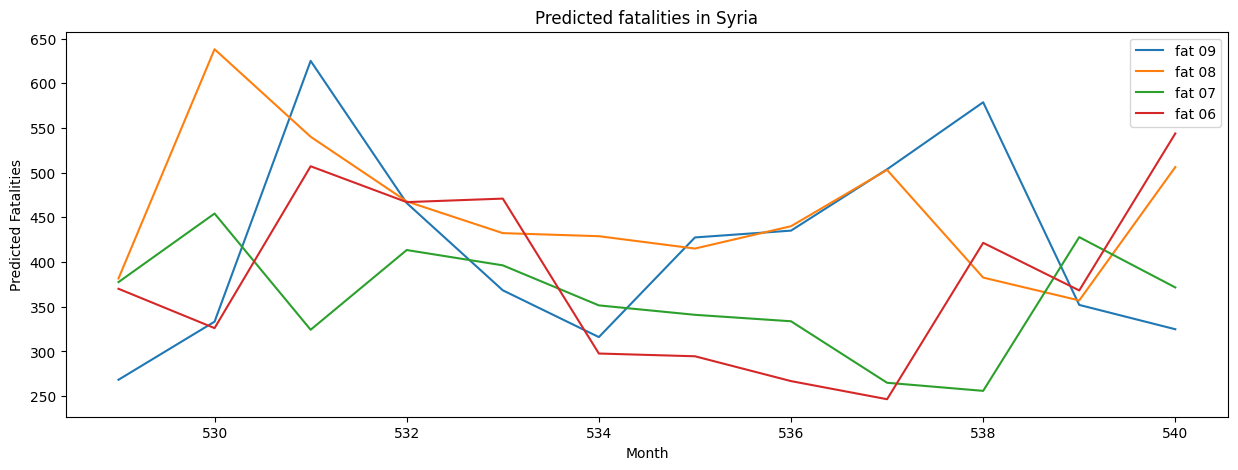

In [190]:
# line graph pulling from four diff fat runs 

plt.plot(df_syria_views_09['month_id'], df_syria_views_09['main_mean'], label='fat 09') #come up with label names
plt.plot(df_syria_views_08['month_id'], df_syria_views_08['main_mean'], label='fat 08')
plt.plot(df_syria_views_07['month_id'], df_syria_views_07['main_mean'], label='fat 07')
plt.plot(df_syria_views_06['month_id'], df_syria_views_06['main_mean'], label='fat 06')

#set_figwidth()
plt.rcParams["figure.figsize"] = (15, 5) # REVISE

# Customize
plt.title('Predicted fatalities in Syria') # REVISE
plt.xlabel('Month')
plt.ylabel('Predicted Fatalities')
#plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees #UNSURE REVISE

# show legend
plt.legend()

# Adjust the layout
#plt.grid()
#plt.tight_layout()

plt.show() # consider adding more months. High variance between predictions for each month in 2024? Attempt to change colour scheme to a gradient from lightest-darkest 

Needs refinement to become something more meaningful, but can see how as input data changes (i.e. in regards to updated conflict history) the predictions have varied.

#### 3.4 Surrogate Models

Touching upon this depends on if the surrogate models are something that we may want to be asked about.

##### 3.4.1 Syria

In [174]:
# When pulling the previous fat runs keep the surrogate model variables?

columns_surrogate = ['country_id', 'month_id', 'name', 'year', 'main_mean', 'surrogate_mean_ch', 'surrogate_mean_pop', 'surrogate_mean_imr', 'surrogate_mean_nch']
df_surrogate_09 = df_views_09[columns_surrogate]
df_surrogate_09

,country_id,month_id,name,year,main_mean,surrogate_mean_ch,surrogate_mean_pop,surrogate_mean_imr,surrogate_mean_nch
0,1,526,Guyana,2023,0.0173,0.0738,0.1187,0.7607,1.8999
1,2,526,Suriname,2023,0.0148,0.0738,0.1122,0.5193,0.3468
2,3,526,Trinidad and Tobago,2023,0.0098,0.0738,0.1437,0.4944,0.1001
3,4,526,Venezuela,2023,1.8027,0.0738,1.3300,0.6946,1.8999
4,5,526,Samoa,2023,0.0113,0.0738,0.0988,0.4881,0.1001
...,...,...,...,...,...,...,...,...,...
6871,242,561,Tanzania,2026,1.3106,0.2509,4.6162,1.5266,14.6752
6872,243,561,Morocco,2026,0.7701,0.2509,2.3745,0.7758,1.0761
6873,244,561,Mauritania,2026,0.9786,0.2509,0.4193,1.4420,3.1183
6874,245,561,Sudan,2026,140.9269,247.4497,3.0542,1.7697,14.8647


In [176]:
# for 2024 

df_surrogate_09_2024 = df_surrogate_09[(df_surrogate_09['year'] == 2024)]
df_surrogate_09_2024

,country_id,month_id,name,year,main_mean,surrogate_mean_ch,surrogate_mean_pop,surrogate_mean_imr,surrogate_mean_nch
573,1,529,Guyana,2024,0.0196,0.1047,0.1328,0.8471,2.0705
574,2,529,Suriname,2024,0.0236,0.1047,0.1260,0.6048,0.3811
575,3,529,Trinidad and Tobago,2024,0.0114,0.1047,0.1587,0.5779,0.1050
576,4,529,Venezuela,2024,3.0522,0.1047,1.4241,0.7839,2.0705
577,5,529,Samoa,2024,0.0099,0.1047,0.1121,0.5711,0.1050
...,...,...,...,...,...,...,...,...,...
2860,242,540,Tanzania,2024,0.9047,0.1682,3.9609,1.3254,10.1362
2861,243,540,Morocco,2024,0.8749,0.1682,2.0258,0.6532,0.9771
2862,244,540,Mauritania,2024,0.5544,0.1682,0.3261,1.2450,2.7642
2863,245,540,Sudan,2024,102.4740,447.1398,2.6116,1.5666,10.3254


In [179]:
# surrogate Syria 

df_surrogate_09_syria = df_surrogate_09_2024[(df_surrogate_09_2024['name'] == 'Syria')]
df_surrogate_09_syria # can calculate percents of deaths attributable to the surrogate model

,country_id,month_id,name,year,main_mean,surrogate_mean_ch,surrogate_mean_pop,surrogate_mean_imr,surrogate_mean_nch
750,220,529,Syria,2024,268.2791,191.8233,1.0400,0.7013,8.9202
941,220,530,Syria,2024,333.2893,183.1930,1.0354,0.6950,8.6930
1132,220,531,Syria,2024,625.0493,201.8781,1.0864,0.7264,9.1274
1323,220,532,Syria,2024,466.0050,182.6796,1.0770,0.7467,9.0202
1514,220,533,Syria,2024,368.3730,161.8899,1.0594,0.7428,8.7362
1705,220,534,Syria,2024,316.0292,173.2461,1.0999,0.7646,8.7511
1896,220,535,Syria,2024,427.5137,169.6430,1.1197,0.7777,8.8221
2087,220,536,Syria,2024,435.1350,153.2018,1.1071,0.7534,8.8495
2278,220,537,Syria,2024,503.7834,169.2099,1.0946,0.7492,8.6497
2469,220,538,Syria,2024,578.7530,145.2767,1.1042,0.7426,8.7667


In [ ]:
# Contuine working on visualisations

# Surrorgate models - try first for Syria. Determine which surrorgate models may be important. 


## Part 4: Creating Low-Violence Watchlist

Exploring and extracting subset of UCDP GED/UCDP Candidate data to determine countries with less than 25 battle-related deaths thus far for 2023. Selecting top five countries with less than 25 total BRDs, and at least 1 BRD



In [24]:
# filter total_ged between 1 and 25 then select top 5

ged_df_filter = ged_df[(ged_df['total_ged'] >= 1) & (ged_df['total_ged'] <= 25)]

ged_df_filter

country_name  ged_best_sb  total_ged
month_id country_id                                     
517      4             Venezuela          0.0       11.0
         13                 Peru          0.0        6.0
         17               Mexico          5.0       14.0
         42                Ghana          0.0        1.0
         52              Senegal          1.0        1.0
...                          ...          ...        ...
525      232              Kosovo          4.0        4.0
         235              Uganda          0.0        7.0
         243             Morocco          0.0        1.0
         244          Mauritania          0.0        6.0
         246         South Sudan          0.0       12.0

[216 rows x 3 columns]

In [26]:
list(ged_df_filter.country_name.unique())

['Venezuela',
 'Peru',
 'Mexico',
 'Ghana',
 'Senegal',
 'Algeria',
 'Benin',
 'France',
 'Armenia',
 'Saudi Arabia',
 'Tajikistan',
 'Bangladesh',
 'Vietnam',
 'Rwanda',
 'South Africa',
 'Swaziland',
 'Canada',
 'Libya',
 'Egypt',
 'Kosovo',
 'Uganda',
 'Morocco',
 'Mauritania',
 'South Sudan']

In [27]:
# pull all unique country_id

lv_countries_filter = ged_df_filter.country_name.unique()

# filter views df  
df_lv_filter = df_2024_views[df_2024_views['name'].isin(lv_countries_filter)]

df_lv_filter

,country_id,month_id,name,gwcode,year,main_mean,isoab
767,4,529,Venezuela,101,2024,2.8892,VEN
776,13,529,Peru,135,2024,0.7649,PER
779,17,529,Mexico,70,2024,2.1965,MEX
804,42,529,Ghana,452,2024,0.2328,GHA
812,52,529,Senegal,433,2024,0.2953,SEN
...,...,...,...,...,...,...,...
3046,232,540,Kosovo,347,2024,0.0434,None
3049,235,540,Uganda,500,2024,3.0467,UGA
3052,243,540,Morocco,600,2024,0.7315,MAR
3053,244,540,Mauritania,435,2024,0.6346,MRT


In [29]:
df_lv_group = df_lv_filter.groupby(['name'])['main_mean'].sum().reset_index()

df_lv_group

,name,main_mean
0,Algeria,9.0931
1,Armenia,12.8093
2,Bangladesh,13.1015
3,Benin,33.7612
4,Canada,1.7080
5,Egypt,27.0702
6,France,6.0847
7,Ghana,6.8178
8,Kosovo,0.2950
9,Libya,14.3727


In [79]:
# pulling top five countries 
n = 5
df_top_lv_2024 = df_lv_group.nlargest(n, 'main_mean')

df_top_lv_2024.reset_index(drop=True, inplace=True)
df_top_lv_2024.index = df_top_lv_2024.index + 1

df_top_lv_2024.index.name = 'Ranking'
# rename column main_mean

df_top_lv_2024 = df_top_lv_2024.rename(columns={'name': 'Country', 'main_mean': 'Total Predicted Fatalities for 2024'})

df_top_lv_2024

,Country,Total Predicted Fatalities for 2024
Ranking,,
1,Benin,33.7612
2,South Africa,32.9503
3,Venezuela,31.0057
4,Egypt,27.0702
5,Uganda,23.2715


Benin, South Africa, Venezuela, Egypt, and Uganda are the top five countries who have not yet exceeded 25 BRDs in 2023 (using GED data ending August 2023) based on the October run. 

In [34]:
# Top five lv countries 

lv_top_five = ['Benin', 'South Africa', 'Venezuela', 'Egypt', 'Uganda']

df_lv_country_filter = df_2024_views[df_2024_views['name'].isin(lv_top_five)]

df_lv_filter_cm = df_lv_country_filter[columns_to_keep_cm]

df_lv_filter_cm.set_index(['month_id', 'country_id'], inplace=True)

df_lv_filter_cm

name  main_mean
month_id country_id                         
529      4              Venezuela     2.8892
         74                 Benin     2.6459
         163         South Africa     2.5337
         222                Egypt     1.2069
         235               Uganda     1.3469
530      4              Venezuela     2.3431
         74                 Benin     2.2120
         163         South Africa     2.3861
         222                Egypt     1.5445
         235               Uganda     1.4761
531      4              Venezuela     2.5829
         74                 Benin     2.5639
         163         South Africa     2.2252
         222                Egypt     1.6859
         235               Uganda     1.3038
532      4              Venezuela     2.0429
         74                 Benin     2.5266
         163         South Africa     3.0221
         222                Egypt     2.1428
         235               Uganda     2.0083
533      4              Venezuela     2.4480
         74                 Benin     3.0874
         163         South Africa     3.1995
         222                Egypt     2.2153
         235               Uganda     1.7666
534      4              Venezuela     2.3876
         74                 Benin     3.0747
         163         South Africa     2.1167
         222                Egypt     2.6482
         235               Uganda     1.6720
535      4              Venezuela     1.8924
         74                 Benin     2.4294
         163         South Africa     1.5097
         222                Egypt     2.1002
         235               Uganda     1.4137
536      4              Venezuela     2.6703
         74                 Benin     2.0404
         163         South Africa     2.1445
         222                Egypt     2.0275
         235               Uganda     1.6458
537      4              Venezuela     2.7931
         74                 Benin     2.4872
         163         South Africa     3.3739
         222                Egypt     2.2524
         235               Uganda     2.0609
538      4              Venezuela     2.9421
         74                 Benin     2.7387
         163         South Africa     4.4745
         222                Egypt     3.0938
         235               Uganda     2.4317
539      4              Venezuela     3.2217
         74                 Benin     4.6355
         163         South Africa     3.2210
         222                Egypt     3.8071
         235               Uganda     3.0990
540      4              Venezuela     2.7924
         74                 Benin     3.3195
         163         South Africa     2.7434
         222                Egypt     2.3456
         235               Uganda     3.0467

In [35]:
pivot_df_lv = df_lv_filter_cm.pivot_table(index='name', columns='month_id', values='main_mean', aggfunc='sum')

pivot_df_lv

# need to put countries in ranking order - currenlty in alphabetical
# pivoted to have data in correct format for visulisations


month_id,529,530,531,532,533,534,535,536,537,538,539,540
name,,,,,,,,,,,,
Benin,2.6459,2.2120,2.5639,2.5266,3.0874,3.0747,2.4294,2.0404,2.4872,2.7387,4.6355,3.3195
Egypt,1.2069,1.5445,1.6859,2.1428,2.2153,2.6482,2.1002,2.0275,2.2524,3.0938,3.8071,2.3456
South Africa,2.5337,2.3861,2.2252,3.0221,3.1995,2.1167,1.5097,2.1445,3.3739,4.4745,3.2210,2.7434
Uganda,1.3469,1.4761,1.3038,2.0083,1.7666,1.6720,1.4137,1.6458,2.0609,2.4317,3.0990,3.0467
Venezuela,2.8892,2.3431,2.5829,2.0429,2.4480,2.3876,1.8924,2.6703,2.7931,2.9421,3.2217,2.7924


### Part 4.5: Low-Violence Visualisations

In [80]:
# Processing data to create a pivot_table that keeps the sorted 'ranked' order of countries for a heatmap
df_lv_pivot = df_lv_country_filter[columns_to_keep_cm]

merged_lv = pd.merge(df_lv_pivot, df_top_lv_2024, left_on='name', right_on='Country')

merged_lv_filter = merged_lv.drop(columns='name')
merged_lv_filter.set_index(['month_id', 'country_id'], inplace=True)

merged_lv_filter

,,main_mean,Country,Total Predicted Fatalities for 2024
month_id,country_id,,,
529,4,2.8892,Venezuela,31.0057
530,4,2.3431,Venezuela,31.0057
531,4,2.5829,Venezuela,31.0057
532,4,2.0429,Venezuela,31.0057
533,4,2.4480,Venezuela,31.0057
534,4,2.3876,Venezuela,31.0057
535,4,1.8924,Venezuela,31.0057
536,4,2.6703,Venezuela,31.0057
537,4,2.7931,Venezuela,31.0057


In [82]:
df_lv_rank = merged_lv_filter.sort_values(by='Total Predicted Fatalities for 2024', ascending=False)

df_lv_rank # Dataframe of all neccessary data in sorted ranked order

,,main_mean,Country,Total Predicted Fatalities for 2024
month_id,country_id,,,
529,74,2.6459,Benin,33.7612
530,74,2.2120,Benin,33.7612
540,74,3.3195,Benin,33.7612
539,74,4.6355,Benin,33.7612
538,74,2.7387,Benin,33.7612
537,74,2.4872,Benin,33.7612
536,74,2.0404,Benin,33.7612
535,74,2.4294,Benin,33.7612
534,74,3.0747,Benin,33.7612


In [83]:
pivot_df_lv_rank = df_lv_rank.pivot_table(index='Country', columns='month_id', values='main_mean', aggfunc='sum', sort=False)

pivot_df_lv_rank # sorted in order of top 1-5

month_id,529,530,531,532,533,534,535,536,537,538,539,540
Country,,,,,,,,,,,,
Benin,2.6459,2.2120,2.5639,2.5266,3.0874,3.0747,2.4294,2.0404,2.4872,2.7387,4.6355,3.3195
South Africa,2.5337,2.3861,2.2252,3.0221,3.1995,2.1167,1.5097,2.1445,3.3739,4.4745,3.2210,2.7434
Venezuela,2.8892,2.3431,2.5829,2.0429,2.4480,2.3876,1.8924,2.6703,2.7931,2.9421,3.2217,2.7924
Egypt,1.2069,1.5445,1.6859,2.1428,2.2153,2.6482,2.1002,2.0275,2.2524,3.0938,3.8071,2.3456
Uganda,1.3469,1.4761,1.3038,2.0083,1.7666,1.6720,1.4137,1.6458,2.0609,2.4317,3.0990,3.0467


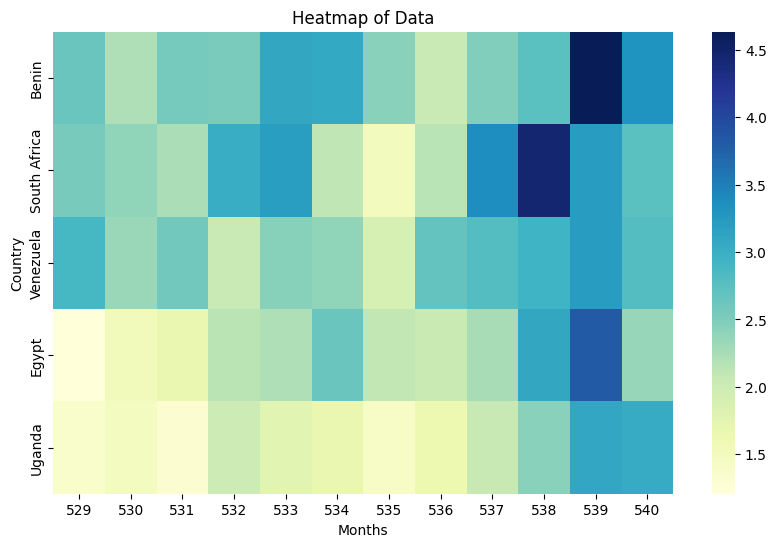

In [84]:
# creating heatmap
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.heatmap(pivot_df_lv_rank, cmap='YlGnBu', vmin=pivot_df_lv_rank.values.min(), vmax=pivot_df_lv_rank.values.max())

# Adding labels and title
plt.xlabel('Months')  # is it possible to add these all together into one line of code?
plt.ylabel('Country')
plt.title('Heatmap of Data')

# Displaying heatmap
plt.show()

In [85]:
# Contuine working on visualisations, start on basic graph 


# Surrorgate models, break down by country? See what is contirbuting to each in different ways 

KeyError: 'month_id'